In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
seed = 0
plot = True

rng = np.random.RandomState(seed)

innerstepsize = 0.02 # stepsize in inner SGD

innerepochs = 1 # number of epochs of each inner SGD

outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization

niterations = 60000 # number of outer updates; each iteration we sample one task and update on it

# Define task distribution
x_all = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 10 # Size of training minibatches

In [3]:
def gen_task():
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

In [4]:
num_hidden = 64
num_classes = 1
num_feature = 1

In [5]:
class Model(tf.keras.layers.Layer):
    
    def __init__(self):
        super(Model, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(num_hidden, activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(num_hidden, activation='tanh')        
        self.dense_3 = tf.keras.layers.Dense(num_classes, activation='linear')    
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)        
        return x

In [6]:
mlp = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 1)))

optimizer = tf.keras.optimizers.SGD(learning_rate=innerstepsize)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [7]:
# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

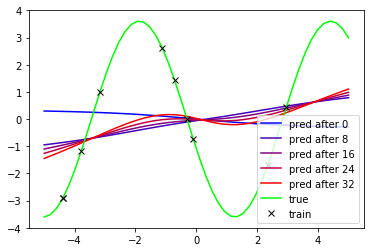

-----------------------------
iteration               1
loss on plotted curve   5.327


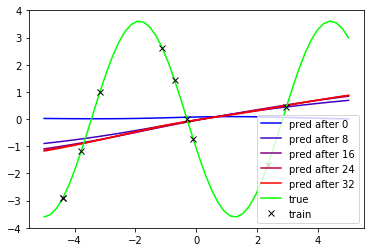

-----------------------------
iteration               1000
loss on plotted curve   6.442


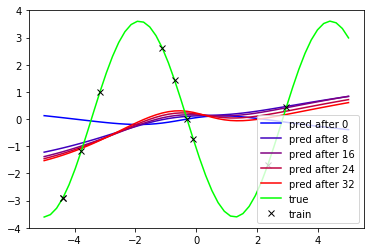

-----------------------------
iteration               2000
loss on plotted curve   5.881


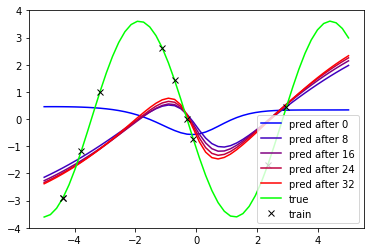

-----------------------------
iteration               3000
loss on plotted curve   3.523


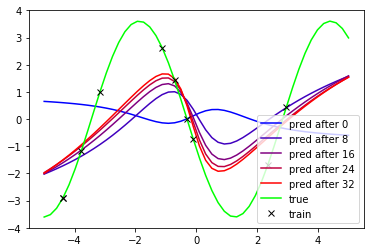

-----------------------------
iteration               4000
loss on plotted curve   2.603


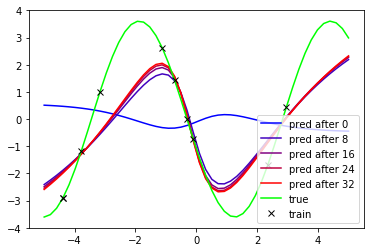

-----------------------------
iteration               5000
loss on plotted curve   1.640


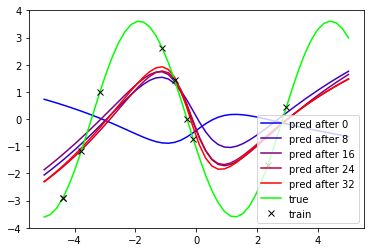

-----------------------------
iteration               6000
loss on plotted curve   2.412


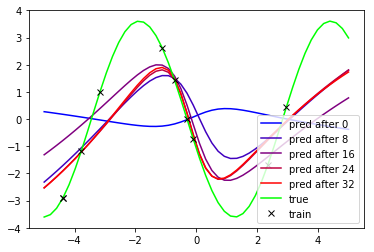

-----------------------------
iteration               7000
loss on plotted curve   2.158


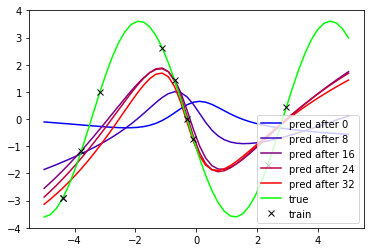

-----------------------------
iteration               8000
loss on plotted curve   2.761


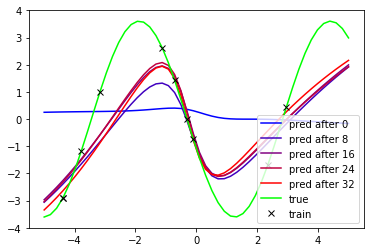

-----------------------------
iteration               9000
loss on plotted curve   2.155


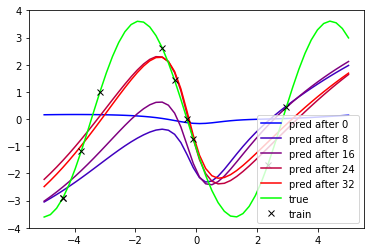

-----------------------------
iteration               10000
loss on plotted curve   1.899


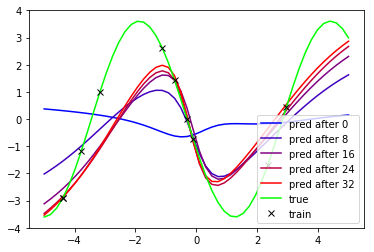

-----------------------------
iteration               11000
loss on plotted curve   1.886


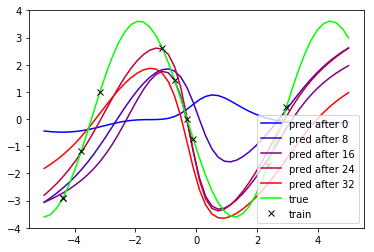

-----------------------------
iteration               12000
loss on plotted curve   2.744


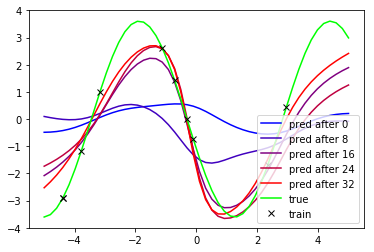

-----------------------------
iteration               13000
loss on plotted curve   0.741


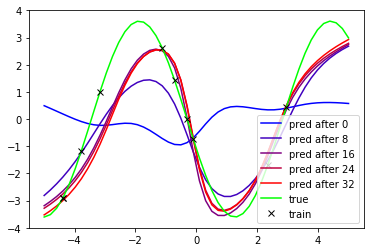

-----------------------------
iteration               14000
loss on plotted curve   0.928


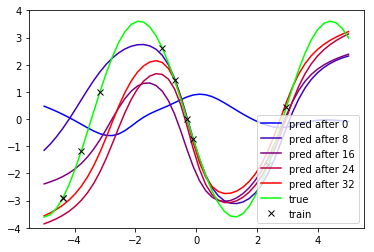

-----------------------------
iteration               15000
loss on plotted curve   1.159


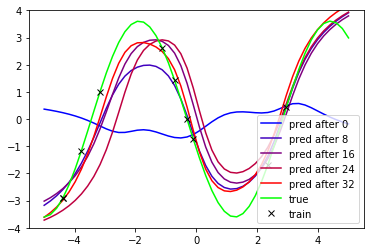

-----------------------------
iteration               16000
loss on plotted curve   0.358


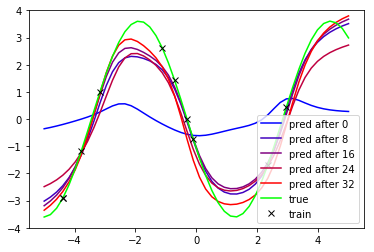

-----------------------------
iteration               17000
loss on plotted curve   0.230


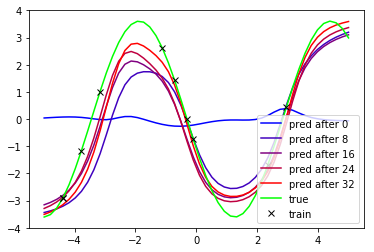

-----------------------------
iteration               18000
loss on plotted curve   0.402


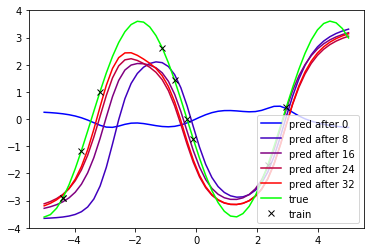

-----------------------------
iteration               19000
loss on plotted curve   0.456


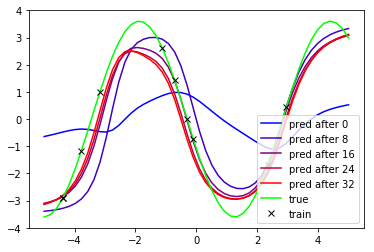

-----------------------------
iteration               20000
loss on plotted curve   0.421


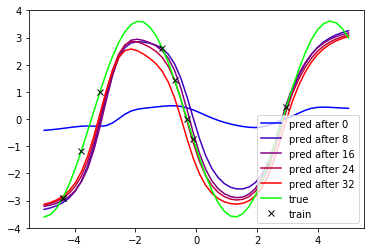

-----------------------------
iteration               21000
loss on plotted curve   0.422


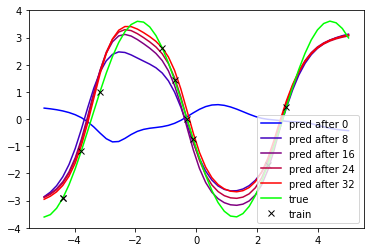

-----------------------------
iteration               22000
loss on plotted curve   0.232


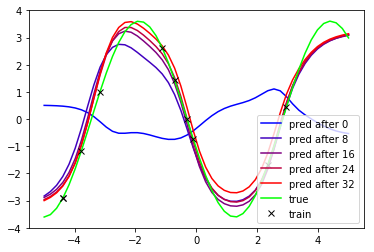

-----------------------------
iteration               23000
loss on plotted curve   0.243


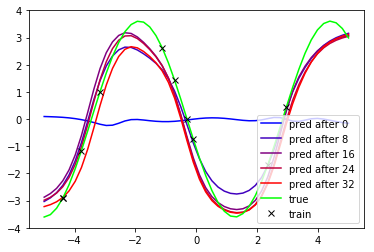

-----------------------------
iteration               24000
loss on plotted curve   0.392


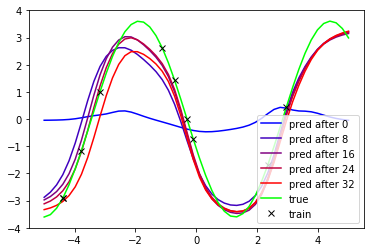

-----------------------------
iteration               25000
loss on plotted curve   0.439


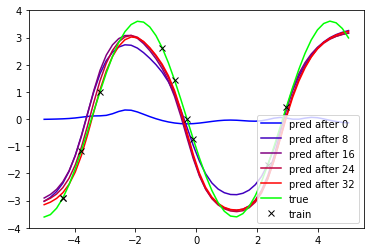

-----------------------------
iteration               26000
loss on plotted curve   0.176


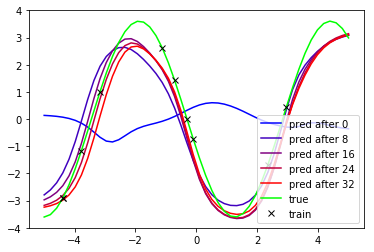

-----------------------------
iteration               27000
loss on plotted curve   0.414


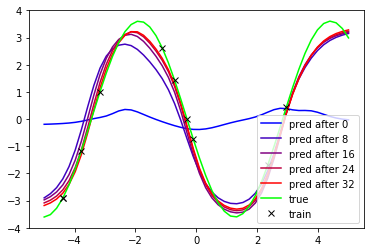

-----------------------------
iteration               28000
loss on plotted curve   0.101


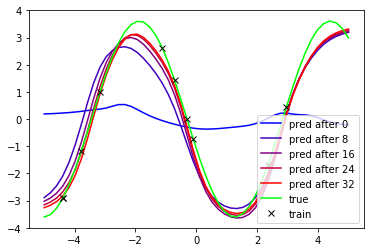

-----------------------------
iteration               29000
loss on plotted curve   0.121


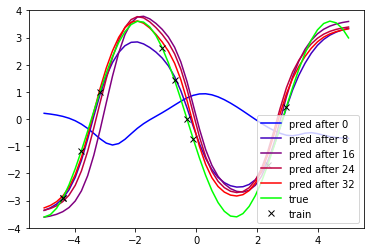

-----------------------------
iteration               30000
loss on plotted curve   0.164


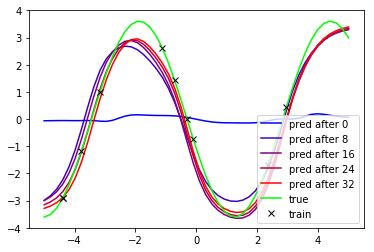

-----------------------------
iteration               31000
loss on plotted curve   0.165


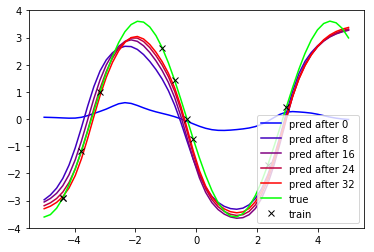

-----------------------------
iteration               32000
loss on plotted curve   0.135


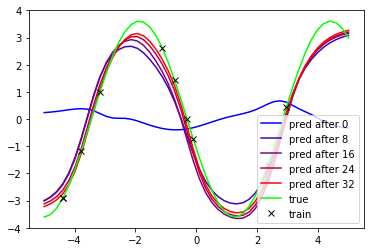

-----------------------------
iteration               33000
loss on plotted curve   0.108


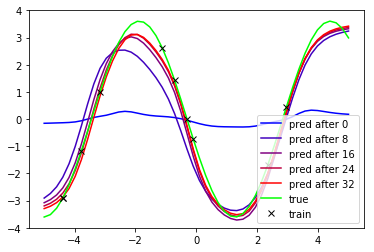

-----------------------------
iteration               34000
loss on plotted curve   0.085


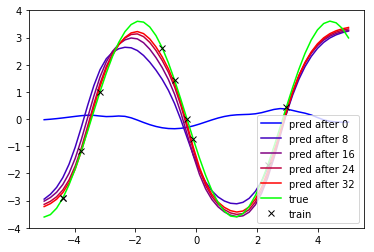

-----------------------------
iteration               35000
loss on plotted curve   0.072


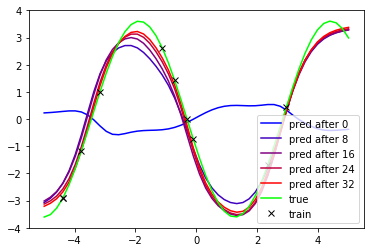

-----------------------------
iteration               36000
loss on plotted curve   0.071


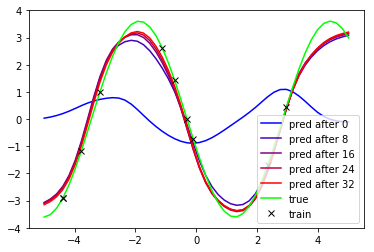

-----------------------------
iteration               37000
loss on plotted curve   0.101


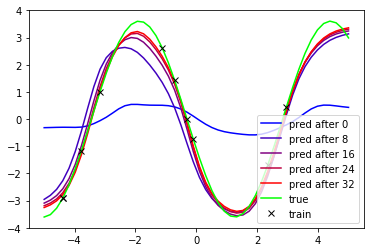

-----------------------------
iteration               38000
loss on plotted curve   0.067


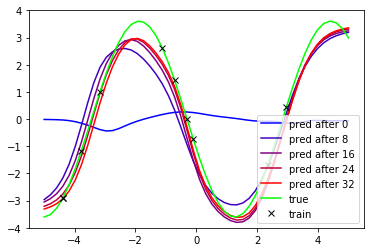

-----------------------------
iteration               39000
loss on plotted curve   0.174


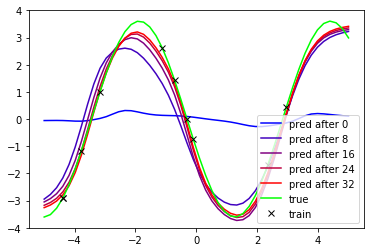

-----------------------------
iteration               40000
loss on plotted curve   0.067


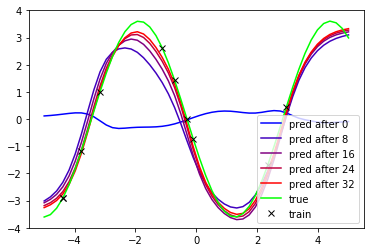

-----------------------------
iteration               41000
loss on plotted curve   0.071


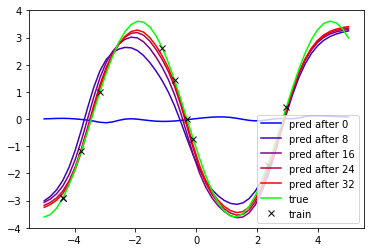

-----------------------------
iteration               42000
loss on plotted curve   0.050


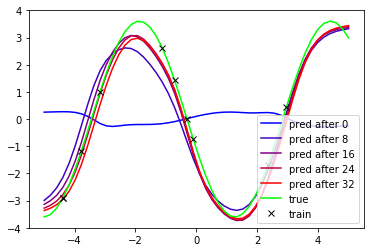

-----------------------------
iteration               43000
loss on plotted curve   0.186


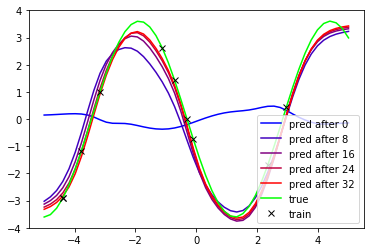

-----------------------------
iteration               44000
loss on plotted curve   0.079


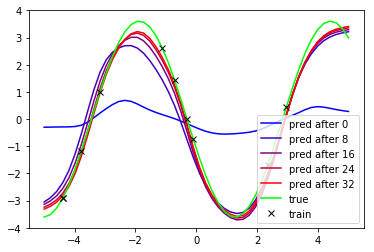

-----------------------------
iteration               45000
loss on plotted curve   0.073


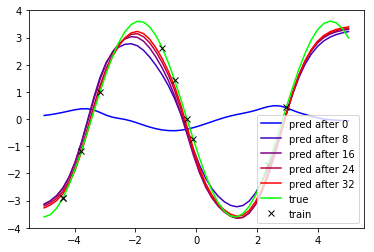

-----------------------------
iteration               46000
loss on plotted curve   0.072


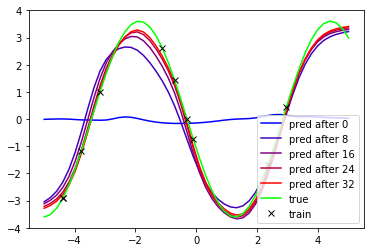

-----------------------------
iteration               47000
loss on plotted curve   0.050


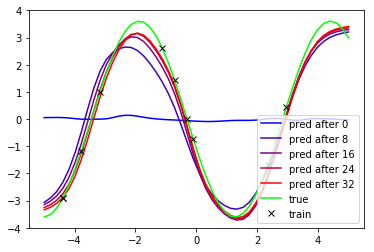

-----------------------------
iteration               48000
loss on plotted curve   0.098


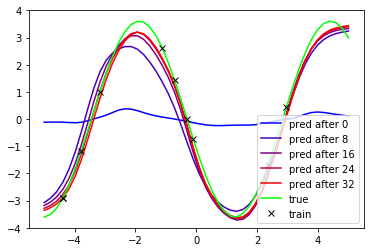

-----------------------------
iteration               49000
loss on plotted curve   0.088


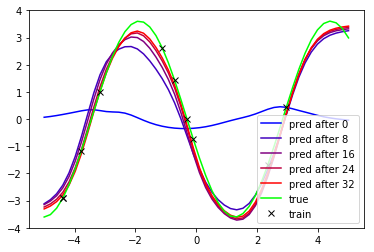

-----------------------------
iteration               50000
loss on plotted curve   0.063


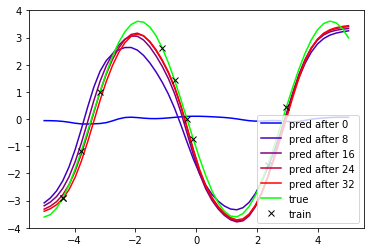

-----------------------------
iteration               51000
loss on plotted curve   0.116


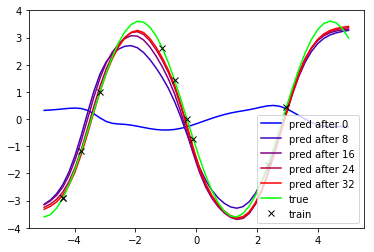

-----------------------------
iteration               52000
loss on plotted curve   0.063


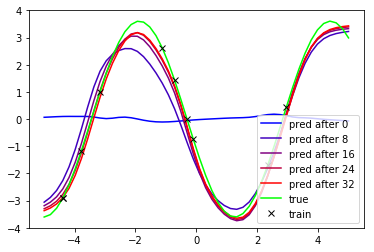

-----------------------------
iteration               53000
loss on plotted curve   0.085


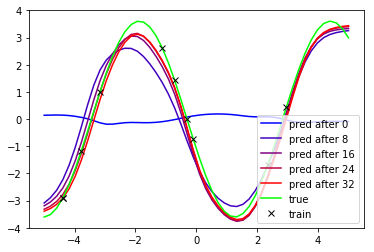

-----------------------------
iteration               54000
loss on plotted curve   0.113


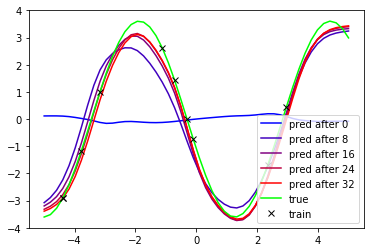

-----------------------------
iteration               55000
loss on plotted curve   0.121


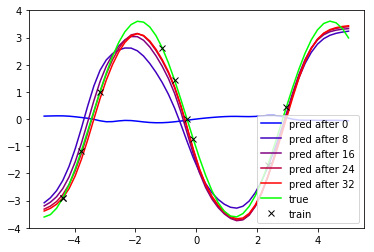

-----------------------------
iteration               56000
loss on plotted curve   0.106


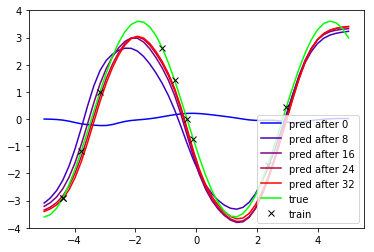

-----------------------------
iteration               57000
loss on plotted curve   0.140


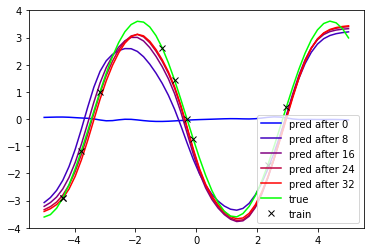

-----------------------------
iteration               58000
loss on plotted curve   0.109


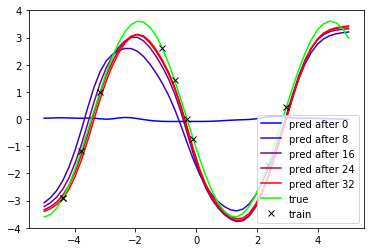

-----------------------------
iteration               59000
loss on plotted curve   0.111


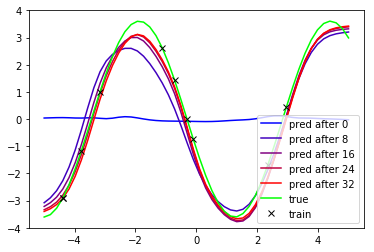

-----------------------------
iteration               60000
loss on plotted curve   0.111


In [8]:
def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y):
    x = to_tensor(x)
    y = to_tensor(y)
    
    with tf.GradientTape() as tape:
        YHat = mlp(x)
        loss = mse_loss_fn(y, YHat)   
        grads = tape.gradient(loss, mlp.trainable_weights)   
    optimizer.apply_gradients(zip(grads, mlp.trainable_weights))
    return loss

def predict(x):
    x = to_tensor(x)
    return mlp(x).numpy()

for iteration in range(niterations):
    
    weights_before = mlp.get_weights()
    
    # Generate task
    f = gen_task()
    y_all = f(x_all)

    inds = rng.permutation(len(x_all))
    
    #for some k number of iterations perform optimization on the task
    for k in range(innerepochs):
        
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
     
    weights_after = mlp.get_weights()
    
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule

    mlp.set_weights([ weights_before[i] + (weights_after[i] - weights_before[i]) * outerstepsize 
        for i in range(len(mlp.weights))])
    
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
       
        weights_before = mlp.get_weights()
        
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        
        for inneriter in range(32):
            
            train_on_batch(xtrain_plot, f(xtrain_plot))  
            
            if (inneriter+1) % 8 == 0:
                frac = (inneriter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
                
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        
        mlp.set_weights(weights_before)
        
        print("-----------------------------")
        print("iteration               {}".format(iteration+1))
        print("loss on plotted curve   {:.3f}".format(lossval))
        

